# 
We hypothesize that stimulus-evoked changes in the LFP aperiodic offset reflect increased spiking activity in the underlying population. This notebook will investigate this hypothesis by computing stimulus-evoked changes in multi-unit spiking activity (MUA), and integrating these results with our previous spectral parameter results.  

## Set-up

#### Set path

In [1]:
# Define paths
PROJECT_PATH = r'G:\Shared drives\v1_v4_1024'


#### Imports

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
import os
from neurodsp.utils import create_times
import pandas as pd

# custom
import sys
sys.path.append("../")
from scripts.utils import load_nix, epoch_neo_segment


#### Settings

In [3]:
# Session of interest (will ultimately apply to all sessions)
SESSIONS = ["A_SNR_041018", "A_SNR_140819", "L_SNR_250717"]
SESSION = "A_SNR_140819"

In [4]:
# Dataset details
N_CHANS = 64 # number of channels per array
N_ARRAYS = 16 # number of arrays per session
DURATION = 0.3 # duration of pre-/post-stimulus epoch (s)
T_MIN = -0.3 # minimum time (s)

#### Functions

## Main

#### Create output directory

In [6]:
# dir_out = f"{PROJECT_PATH}/figures/"
# if not os.path.exists(dir_out):
#     os.makedirs(dir_out)

#### load data

In [5]:
# load LFP spectral parameter results
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
results

,session,channel,chan_idx,array,epoch,offset,knee,exponent,r2
0,A_SNR_140819_lfp_post.json,0,0,1,pre,9.902206,219236.259107,4.409638,0.999214
1,A_SNR_140819_lfp_post.json,1,1,1,pre,9.889650,297544.173538,4.448360,0.999085
2,A_SNR_140819_lfp_post.json,2,2,1,pre,9.352365,88240.849906,4.079099,0.999065
3,A_SNR_140819_lfp_post.json,3,3,1,pre,10.121877,599948.860740,4.603642,0.998497
4,A_SNR_140819_lfp_post.json,4,4,1,pre,9.622889,177268.832549,4.313483,0.999089
...,...,...,...,...,...,...,...,...,...
8187,L_SNR_250717_lfp_pre.json,59,1019,16,post,7.527530,421.936825,2.804417,0.995542
8188,L_SNR_250717_lfp_pre.json,60,1020,16,post,7.350936,214.690632,2.610531,0.996774
8189,L_SNR_250717_lfp_pre.json,61,1021,16,post,7.973004,862.206119,3.011786,0.996864
8190,L_SNR_250717_lfp_pre.json,62,1022,16,post,8.072889,1156.365207,3.075089,0.997915


#### demo importing and plotting MUA data

Sampling rate: 1000.0 Hz
Signal duration: 0.064 s
N channels: 64
N trials: 102


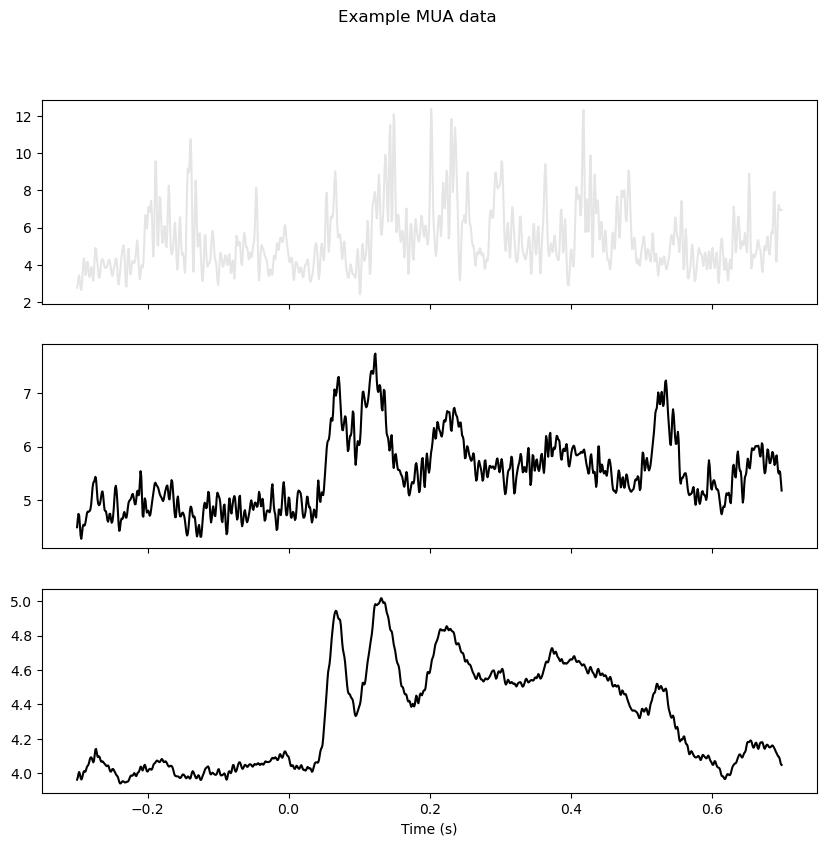

In [8]:
# load example MUA data
fname_in = r"G:\Shared drives\v1_v4_1024\data\dataset\A_SNR_041018\mua\NSP1_array1_MUAe.nix"
segment, analog_signal = load_nix(fname_in)
signal = segment.analogsignals[0].T # transpose to get channels x time
fs = analog_signal._sampling_rate.item()

# epoch data into trials around stimulus times
epochs = epoch_neo_segment(segment, reset_time=True) 
epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

# print info
print(f"Sampling rate: {fs} Hz")
print(f"Signal duration: {signal.duration.item()} s")
print(f"N channels: {signal.shape[0]}")
print(f"N trials: {len(segment.epochs[0])}")

# plot example trial, example channel, and grand average
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=[10,9], sharex=True)
fig.suptitle(f"Example MUA data")
ax1.plot(epoch_times, epochs[0,0,:].T, color="k", alpha=0.1) # plot first trial
ax2.plot(epoch_times, epochs[:,10,:].mean(axis=0), color="k") # plot first channel (mean across trials)
ax3.plot(epoch_times, epochs.mean(axis=(0,1)), color="k") # plot mean across all trials and channels
ax3.set_xlabel("Time (s)")
plt.show()


#### Compute average MUA for the pre-stimulus (-0.3 to 0.0 s) and post-stimulus (0.0 to 0.3 s) period.
add this information to the results dataframe imported above

In [ ]:
## in epochs we originally have channels x time x trials
# with np.mean(epochs, axis=0) we are averaging the trials such that we now have a mean for each channel in all the time points
# so mua_mean.shape is (64,1000)

In [25]:
# average MUA over channels
mua_mean = np.mean(epochs, axis=0) # channels x time
print("mua shape:", mua_mean.shape)
print("epoch_times shape:", epoch_times.shape)


# find indices
idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
print("n sample pre:", np.sum(idx_pre))
idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 
print("n sample post:", np.sum(idx_post))
mua_pre_array = mua_mean[:, idx_pre] # index time dimension
print(mua_pre_array.shape)
# mua_post 
mua_post_array = mua_mean[:, idx_post] # index time dimension
print(mua_post_array.shape)

# take average over each window
mua_pre = np.mean(mua_pre_array, axis=1)
print("mua pre shape", mua_pre.shape)

mua_post = np.mean(mua_post_array, axis=1)
print("mua pre shape", mua_post.shape)

mua shape: (64, 1000)
epoch_times shape: (1000,)
n sample pre: 300
n sample post: 300
(64, 300)
(64, 300)
mua pre shape (64,)
mua pre shape (64,)


In [6]:
dfs =[]

for session in SESSIONS:
    for i_array in range(N_ARRAYS):
        nps_idx = (i_array+2) // 2

        fname_in = f"{PROJECT_PATH}/data/dataset/{session}/mua/NSP{nps_idx}_array{i_array+1}_MUAe.nix"
        print(f"current file: {fname_in}")
        
        # create dataframe for session data
        data = {
            'session'   :   np.repeat(session, N_CHANS),
            'array'     :   np.repeat(i_array, N_CHANS) + 1,
            'channel'   :   np.concatenate([np.arange(N_CHANS)])}
        
        segment, analog_signal = load_nix(fname_in)
        signal = segment.analogsignals[0].T # transpose to get channels x time
        fs = analog_signal._sampling_rate.item()

        # epoch data into trials around stimulus times
        epochs = epoch_neo_segment(segment, reset_time=True) 
        epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

        # average MUA over channels
        mua_mean = np.mean(epochs, axis=0) # channels x time
        
        idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
        idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 

        # loop through epochs 
        for epoch, indices in zip(['pre', 'post'], [idx_pre, idx_post]):
            df_ar = pd.DataFrame(data=data)
            df_ar['epoch'] = epoch

            # index time dimension
            mua_array = mua_mean[:, indices]

            df_ar[f'mua'] = np.mean(mua_array, axis=1)

            # add to list
            dfs.append(df_ar)
        

current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP1_array1_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP1_array2_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP2_array3_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP2_array4_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP3_array5_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP3_array6_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP4_array7_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP4_array8_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP5_array9_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP5_array10_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/m

In [7]:
dfs_out = pd.concat(dfs, ignore_index=True)
# dfs.to_csv(r'C:\Users\Andre\projects\mua_df.csv')
dfs_out.to_csv(f'{PROJECT_PATH}/data/results/mua_df.csv')

#### Plot the stimulus-evoked change in the MUA v. the change in the LFP offset.

In [ ]:
# get dataframe from spectral_params_diff.csv for offset diff
# use the notebook to see also how to calculate diff in mua
# for plotting 
# correlate_specparam_erp scatterplot for plotting diff in both offset and mua

In [ ]:
diff_df = r"G:\Shared drives\v1_v4_1024\data\results\spectral_params_diff.csv"


In [21]:
# load data

In [32]:
fname_in = r"G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_140819/mua/NSP6_array11_MUAe.nix"
segment, analog_signal = load_nix(fname_in)
